# NeoKart Analytics BDM Project Analysis

 1. Import Required Libraries

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA

sns.set(style='whitegrid')

2. Load and Explore Data

In [ ]:
data = pd.read_csv('/content/online_retail_II.csv', encoding='ISO-8859-1')
print("Dataset shape:", data.shape)
print(data.head())

Dataset shape: (1067371, 8)
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


3. Data Cleaning and Preparation

In [ ]:
data.columns = data.columns.str.strip()
data = data.dropna(subset=['Invoice', 'StockCode', 'Quantity', 'Price'])
data = data[data['Price'] > 0].copy()
data['Invoice'] = data['Invoice'].astype(str)
data['IsReturn'] = data['Invoice'].str.startswith('C')
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data = data.drop_duplicates()


4. Stats on missing CustomerID

In [ ]:
missing_customer = data['Customer ID'].isna().sum()
missing_cust_pct = round(missing_customer / len(data) * 100, 2)
print(f"Missing Customer ID: {missing_customer} ({missing_cust_pct}%)")

Missing Customer ID: 229202 (22.32%)


 5. Metadata & Descriptive Statistics

Total Transactions: 1027017
Unique Invoices: 48369
Unique Customers: 5939
Unique Products (StockCode): 4932
Quantity:
 count    1.027017e+06
mean     1.044611e+01
std      1.686340e+02
min     -8.099500e+04
25%      1.000000e+00
50%      3.000000e+00
75%      1.000000e+01
max      8.099500e+04
Name: Quantity, dtype: float64
Price:
 count    1.027017e+06
mean     4.795523e+00
std      9.310805e+01
min      1.000000e-03
25%      1.250000e+00
50%      2.100000e+00
75%      4.150000e+00
max      3.897000e+04
Name: Price, dtype: float64
Top countries (transactions):
 Country
United Kingdom    942329
EIRE               17662
Germany            17331
France             14024
Netherlands         5132
Name: count, dtype: int64


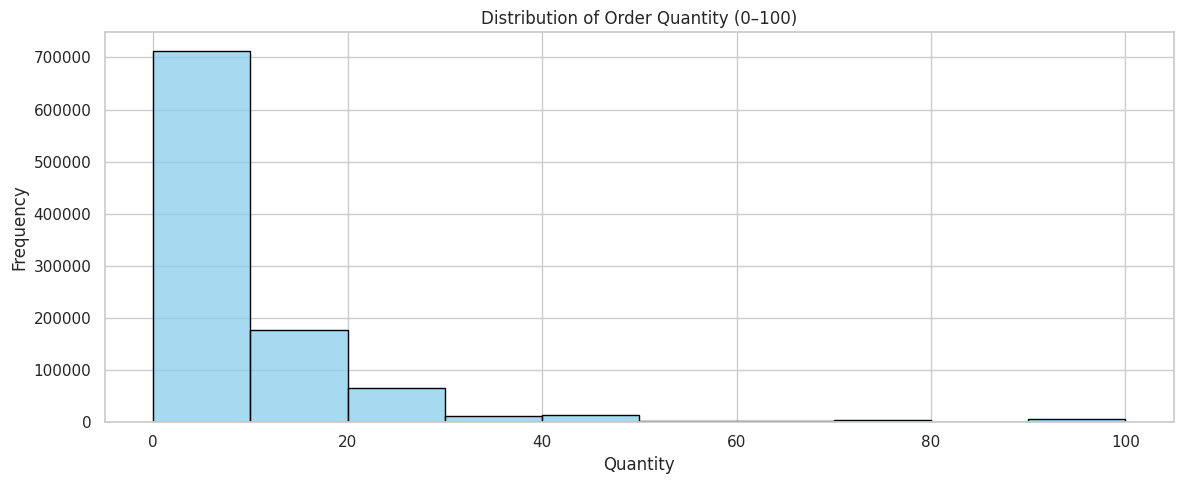

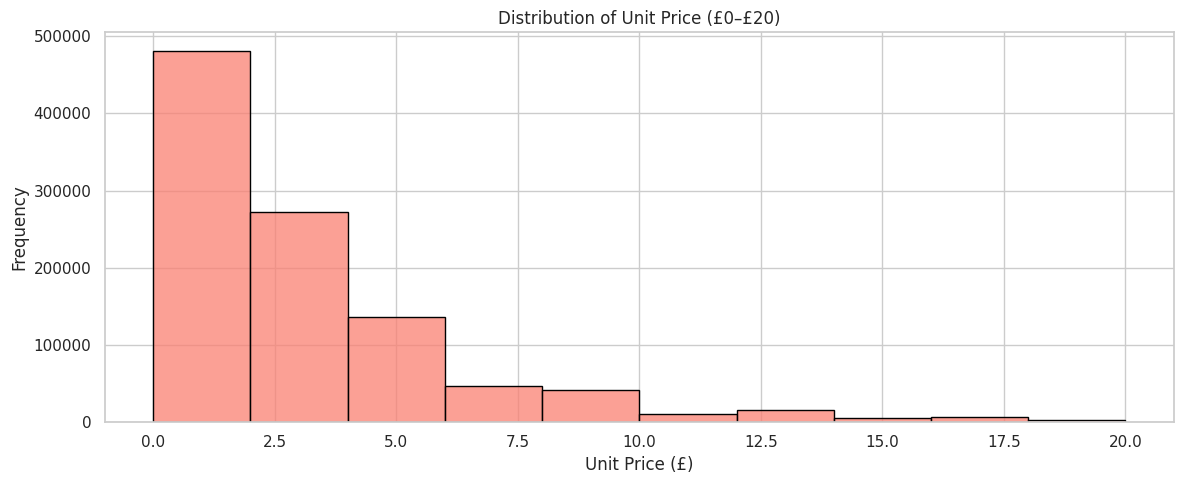

In [ ]:
print("Total Transactions:", len(data))
print("Unique Invoices:", data['Invoice'].nunique())
print("Unique Customers:", data['Customer ID'].nunique())
print("Unique Products (StockCode):", data['StockCode'].nunique())
print("Quantity:\n", data['Quantity'].describe())
print("Price:\n", data['Price'].describe())
print("Top countries (transactions):\n", data['Country'].value_counts().head())


# For Quantity: Focus on majority of orders
plt.figure(figsize=(12, 5))
quantity_bins = np.linspace(0, 100, 11)  # 10 bins: 0-10, 10-20, ..., 90-100
sns.histplot(data[(data['Quantity'] >= 0) & (data['Quantity'] <= 100)]['Quantity'], bins=quantity_bins, color='skyblue', edgecolor='black')
plt.title('Distribution of Order Quantity (0–100)')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('quantity_distribution_proper.png')
plt.show()

# For Price: Focus on £0–£20
plt.figure(figsize=(12, 5))
price_bins = np.linspace(0, 20, 11)
sns.histplot(data[(data['Price'] >= 0) & (data['Price'] <= 20)]['Price'], bins=price_bins, color='salmon', edgecolor='black')
plt.title('Distribution of Unit Price (£0–£20)')
plt.xlabel('Unit Price (£)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('unitprice_distribution_proper.png')
plt.show()




6. Customer Segmentation – RFM Analysis

             Recency  Frequency  Monetary R_Quartile F_Quartile M_Quartile  \
Customer ID                                                                  
12346.0          326         17    -51.74          2          4          1   
12347.0            2          8   4921.53          4          3          4   
12348.0           75          5   2019.40          3          3          3   
12349.0           19          5   4404.54          4          3          4   
12350.0          310          1    334.40          2          1          2   

             RFM_Score  
Customer ID             
12346.0              7  
12347.0             11  
12348.0              9  
12349.0             11  
12350.0              5  


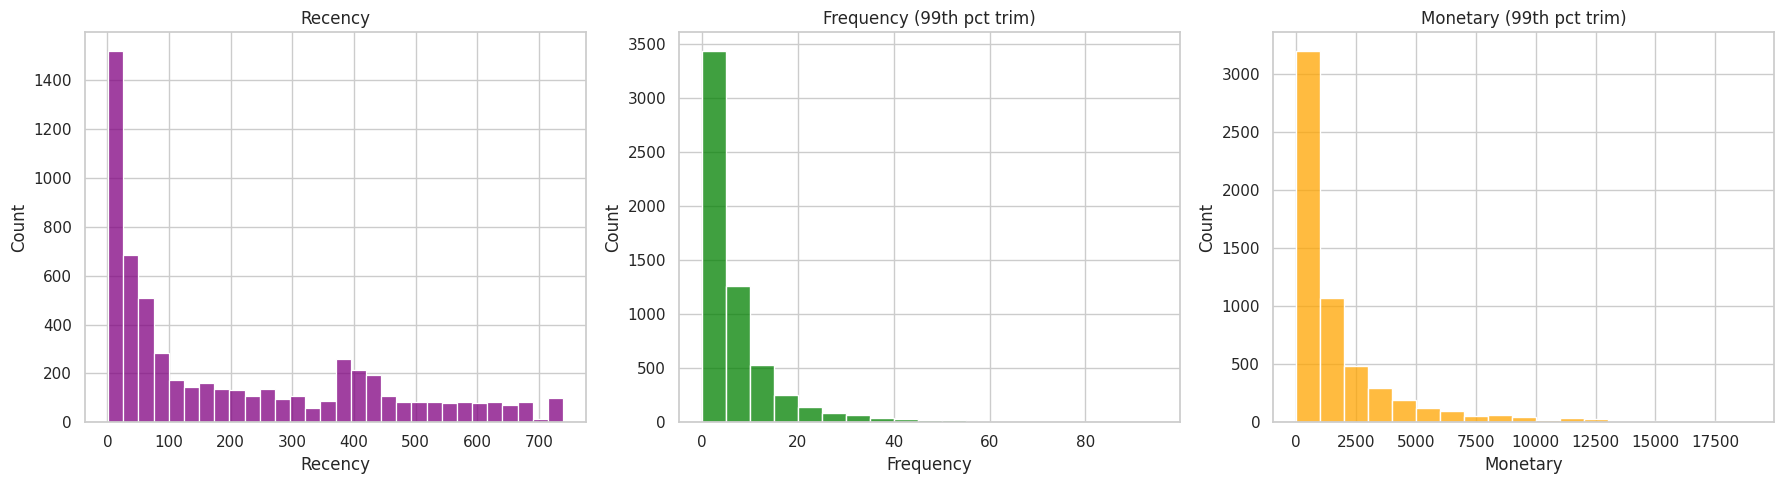

In [ ]:
# RFM Segmentation

cust = data.dropna(subset=['Customer ID']).copy()
cust['TotalPrice'] = cust['Quantity'] * cust['Price']
snapshot = cust['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = cust.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot - x.max()).days,  # Recency
    'Invoice': 'nunique',                                # Frequency
    'TotalPrice': 'sum'                                  # Monetary
}).rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'TotalPrice': 'Monetary'})

rfm['R_Quartile'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_Quartile'] = pd.qcut(rfm['Frequency'], 4, labels=[1,2,3,4])
rfm['M_Quartile'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

rfm['RFM_Score'] = rfm[['R_Quartile','F_Quartile','M_Quartile']].astype(int).sum(axis=1)

print(rfm.head())

# RFM Distribution Plots (trim extreme outliers for F and M)
freq_max = np.percentile(rfm['Frequency'], 99)
mon_max = np.percentile(rfm['Monetary'], 99)

fig, axs = plt.subplots(1, 3, figsize=(18,5))
sns.histplot(rfm['Recency'], bins=30, color='purple', ax=axs[0])
axs[0].set_title('Recency')
sns.histplot(rfm[rfm['Frequency'] <= freq_max]['Frequency'], bins=[i for i in range(0,100,5)], color='green', ax=axs[1])
axs[1].set_title('Frequency (99th pct trim)')
sns.histplot(rfm[rfm['Monetary'] <= mon_max]['Monetary'], bins=[i for i in range(0,20000,1000)], color='orange', ax=axs[2])
axs[2].set_title('Monetary (99th pct trim)')
plt.tight_layout()
plt.show()



 7. Product (SKU) Revenue Pareto Chart

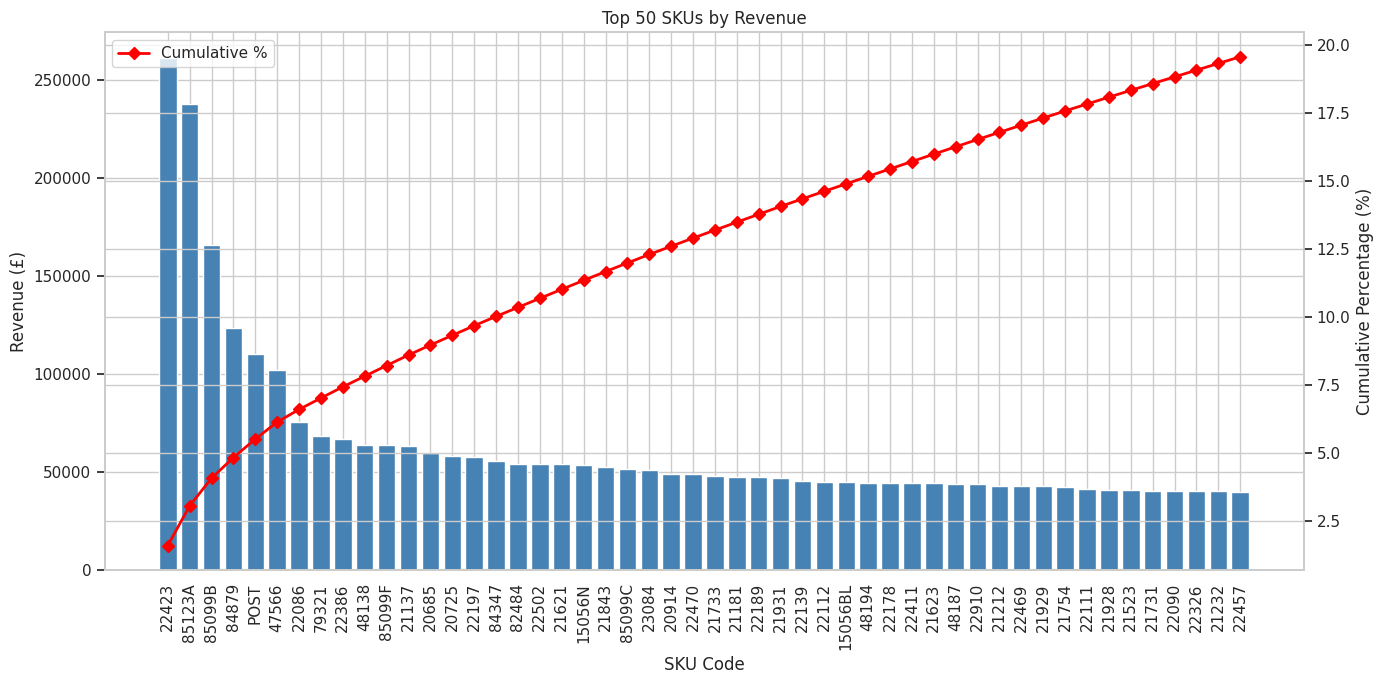

In [ ]:
# SKU Revenue Pareto Chart
sku_revenue = cust.groupby('StockCode')['TotalPrice'].sum().sort_values(ascending=False)
sku_cumperc = 100 * sku_revenue.cumsum() / sku_revenue.sum()

plt.figure(figsize=(14, 7))
plt.bar(sku_revenue.index[:50], sku_revenue.values[:50], color='steelblue')
plt.xticks(rotation=90)
plt.title('Top 50 SKUs by Revenue')
plt.ylabel('Revenue (£)')
plt.xlabel('SKU Code')
plt.twinx()
plt.plot(sku_cumperc[:50], color='red', marker='D', linestyle='-', linewidth=2, label='Cumulative %')
plt.ylabel('Cumulative Percentage (%)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('pareto_sku_revenue.png')
plt.show()


8. Monthly Revenue Trend & ARIMA Forecast

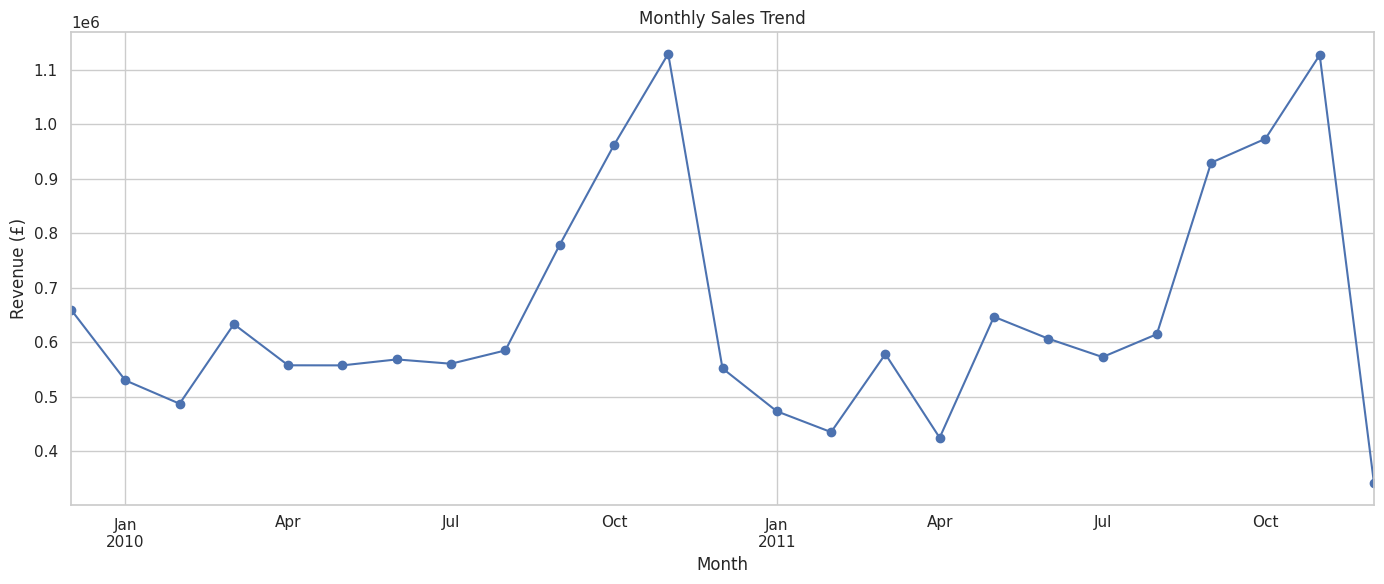

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


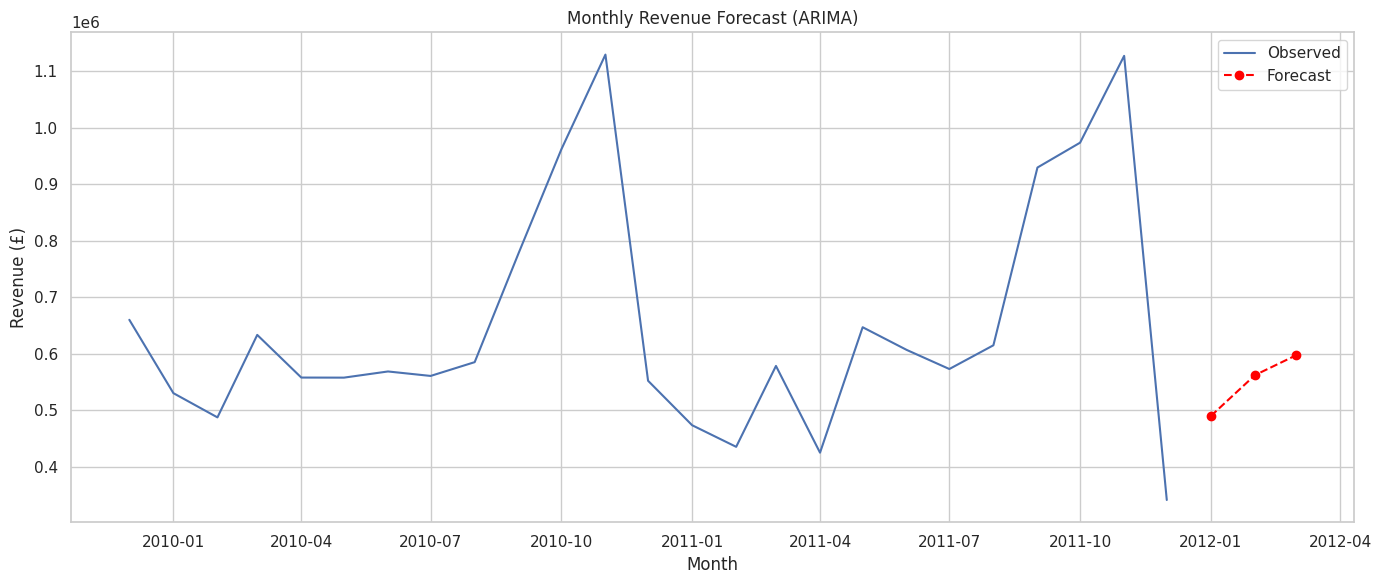

3-Month Forecast Values: [489991.4982948  562247.4513302  597420.79670186]


In [ ]:
# Monthly Sales Trend and Forecast

cust['InvoiceMonth'] = cust['InvoiceDate'].dt.to_period('M')
monthly_sales = cust.groupby('InvoiceMonth')['TotalPrice'].sum()

plt.figure(figsize=(14, 6))
monthly_sales.plot(marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Revenue (£)')
plt.grid(True)
plt.tight_layout()
plt.savefig('monthly_sales_trend.png')
plt.show()

# ARIMA forecasting
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(monthly_sales.values, order=(1, 1, 1))
fit = model.fit()
forecast = fit.forecast(steps=3)
future_index = pd.period_range(monthly_sales.index[-1] + 1, periods=3, freq='M').to_timestamp()

plt.figure(figsize=(14, 6))
plt.plot(monthly_sales.index.to_timestamp(), monthly_sales.values, label='Observed')
plt.plot(future_index, forecast, marker='o', linestyle='--', color='red', label='Forecast')
plt.legend()
plt.title('Monthly Revenue Forecast (ARIMA)')
plt.xlabel('Month')
plt.ylabel('Revenue (£)')
plt.grid(True)
plt.tight_layout()
plt.savefig('sales_forecast.png')
plt.show()

print("3-Month Forecast Values:", forecast)


9. Top 5 Countries by Revenue

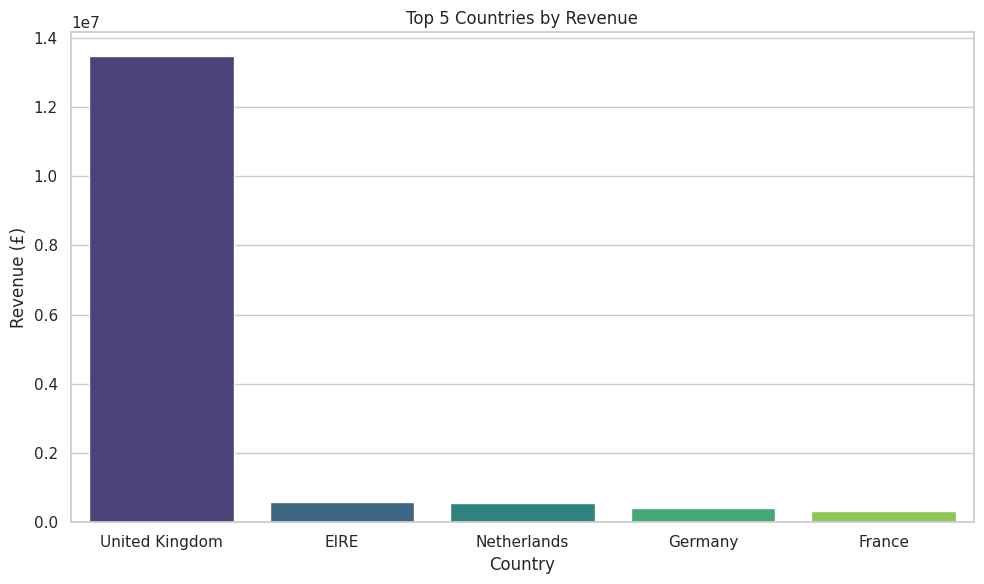

In [ ]:
top_countries = cust.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(5).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=top_countries, x='Country', y='TotalPrice', hue='Country', palette='viridis', legend=False)
plt.title('Top 5 Countries by Revenue')
plt.xlabel('Country')
plt.ylabel('Revenue (£)')
plt.tight_layout()
plt.savefig('top_countries_revenue.png')
plt.show()


10. Returns Percentage by Country

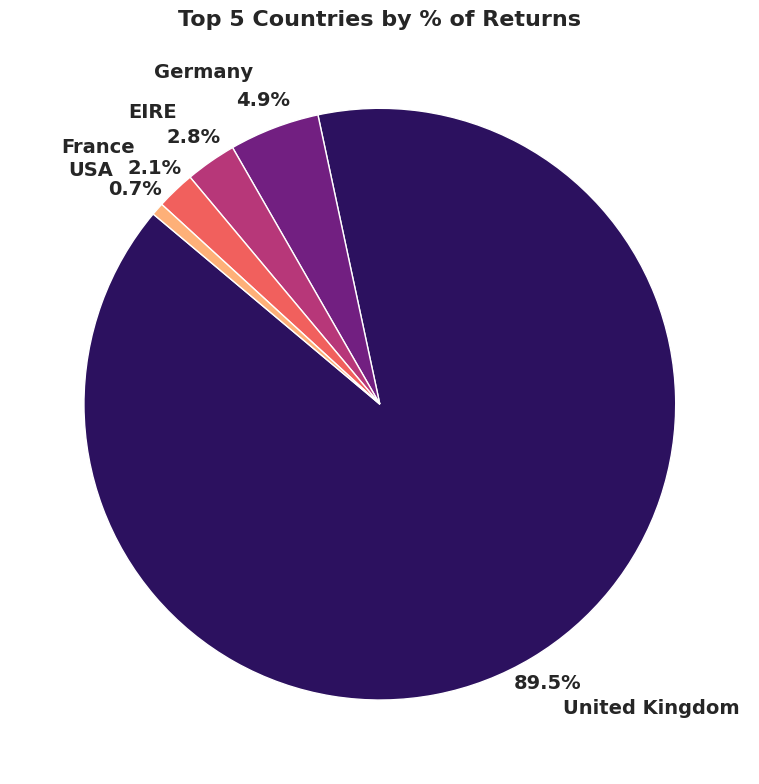

Top 5 Countries by Returns (%):
 Country
United Kingdom    85.275335
Germany            4.705821
EIRE               2.659129
France             2.015285
USA                0.659548
Name: proportion, dtype: float64


In [ ]:
returns = data[data['IsReturn']]
returns_pct = 100 * returns['Country'].value_counts(normalize=True).head(5)

plt.figure(figsize=(8,8))
plt.pie(
    returns_pct.values,
    labels=returns_pct.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('magma', len(returns_pct)),
    pctdistance=1.1,
    labeldistance=1.2,
    textprops={'fontsize': 14, 'weight': 'bold'}
)
plt.title('Top 5 Countries by % of Returns', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

print("Top 5 Countries by Returns (%):\n", returns_pct)

